In [1]:
# Imports
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import make_grid
import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score

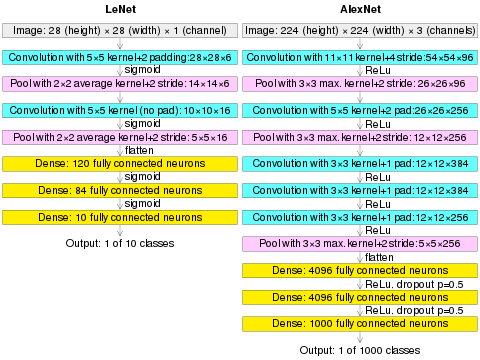

In [2]:
# Download the data

# Will need to resize 28x28 LeNet and 227x227 for AlexNet
transform_train = transforms.Compose([
    transforms.Resize(230),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(227),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize(230),
    transforms.Resize(227),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

training_data = datasets.CIFAR100(
    root = 'data', #directory to store the dataset in
    # True for training dataset, False for testing
    train = True,
    download = True,
    transform = transform_train
)

testing_data = datasets.CIFAR100(
    root = 'data',
    train = False,
    download = True,
    transform = transform_test
)
classes = training_data.classes

# DataLoader pytorch.org/docs/stable/data.html
batch_size = 32
training_dataloader = DataLoader(training_data, batch_size=batch_size)
testing_dataloader = DataLoader(testing_data, batch_size=batch_size)

# For CIFAR-100 we expect 60k total images
# 100 classes with 600 images each
# that's 50k training and 10k testing (500 training/100 testing per class)
print(f'training: {batch_size*len(training_dataloader)}, testing: {batch_size*len(testing_dataloader)}')

Files already downloaded and verified
Files already downloaded and verified
training: 50016, testing: 10016


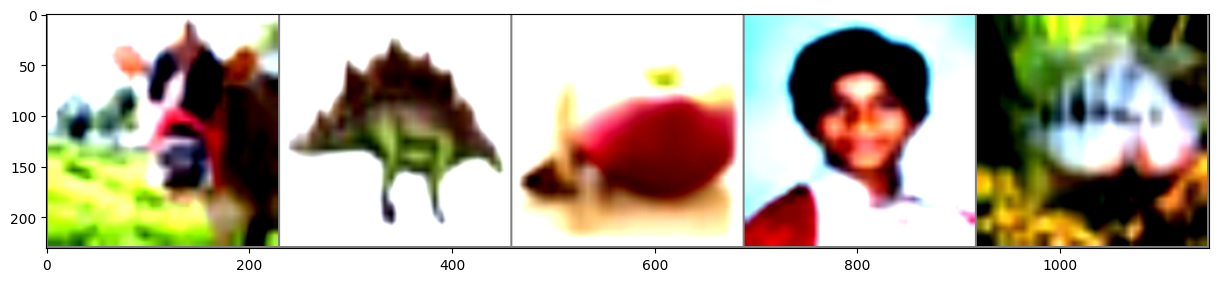

Ordered Labels:
cattle dinosaur apple boy   aquarium_fish


In [3]:
# Peek at the data
# manually verify labels are correct:
# https://huggingface.co/datasets/cifar100

def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.figure(figsize=(15, 15))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(training_dataloader)
images, labels = next(dataiter)
images = images[:5]
labels = labels[:5]

imshow(make_grid(images))
print('Ordered Labels:')
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(5)))

In [4]:
# Define Training/Testing

# train
def train(dataloader, model, loss_fn, optimizer, device):
  model.train()
  # step being a training step
  for step, (X, y) in enumerate(dataloader):
    # send to CPU/GPU
    X = X.to(device)
    y = y.to(device)
    # model's prediction
    pred = model(X)
    # get loss
    loss = loss_fn(pred, y)
    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # progress check
    if step % 100 == 0:
      print(f'step: {step}, loss: {loss.item()}')

# validation
def test(dataloader, model, loss_fn, device):
  num_steps = len(dataloader)
  model.eval()
  test_loss = 0
  correct = 0
  y_true = []
  y_predicted = []

  with torch.no_grad():
    for X, y in dataloader:
      X = X.to(device)
      y = y.to(device)
      pred = model(X)
      loss = loss_fn(pred, y)
      test_loss += loss.item()
      y_true.extend(y.cpu().numpy())
      y_hat = pred.argmax(1)
      y_predicted.extend(y_hat.cpu().numpy())
      correct_step = (y_hat == y).type(torch.float).sum().item()
      correct += correct_step

  test_loss /= num_steps # average loss
  correct = correct / (num_steps * batch_size)
  f1 = f1_score(y_true, y_predicted, average='macro')

  print()
  print(f'F1 Score: {f1}')
  print(f'Test Accuracy: {correct}')

In [5]:
# AlexNet

class AlexNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Sequential(
      nn.Conv2d(in_channels=3,
                out_channels=96,
                kernel_size=11,
                stride=4,
                padding=0),
      nn.BatchNorm2d(96), # Was hoping this might speed up training
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=3,
                   stride=2)
  )
    self.conv2 = nn.Sequential(
      nn.Conv2d(in_channels=96,
                out_channels=256,
                kernel_size=5,
                stride=1,
                padding=2),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=3,
                   stride=2)
  )
    self.conv3 = nn.Sequential(
      nn.Conv2d(in_channels=256,
                out_channels=384,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU()
  )
    self.conv4 = nn.Sequential(
      nn.Conv2d(in_channels=384,
                out_channels=384,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU()
  )
    self.conv5 = nn.Sequential(
      nn.Conv2d(in_channels=384,
                out_channels=256,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=3,
                   stride=2)
  )
    self.flatten = nn.Flatten()
    self.fc1 = nn.Sequential(
        nn.Linear(9216, 4096),
        nn.ReLU(),
        nn.Dropout(0.5)
    )
    self.fc2 = nn.Sequential(
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Dropout(0.5)
    )
    self.fc3 = nn.Sequential(
        nn.Linear(4096, 100), # 100 classes in CIFAR-100
        nn.ReLU()
    )

  def forward(self, x):
    x = self.conv1(x)
    # print(f'size after conv1: {x.size()}')
    x = self.conv2(x)
    # print(f'size after conv2: {x.size()}')
    x = self.conv3(x)
    # print(f'size after conv3: {x.size()}')
    x = self.conv4(x)
    # print(f'size after conv4: {x.size()}')
    x = self.conv5(x)
    # print(f'size after conv5: {x.size()}')
    x = x.reshape(x.size(0), -1)
    # print(f'size after reshape: {x.size()}')
    x = self.fc1(x)
    # print(f'size after fc1: {x.size()}')
    x = self.fc2(x)
    # print(f'size after fc2: {x.size()}')
    logits = self.fc3(x)
    return logits

In [ ]:
# get device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# create model
model = AlexNet().to(device)
epochs = 20
lr = 5e-3
# optimize
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

print(f'Using {device}')
print(f'Optimizer: {optimizer}')
print(f'Epochs {epochs}')
print(f'Batch Size: {batch_size}')
print(f'Model Info: {AlexNet}')

for t in tqdm.tqdm(range(epochs)):
  print(f'Epoch\n\n{t}')
  train(training_dataloader, model, loss_fn, optimizer, device)
  test(testing_dataloader, model, loss_fn, device)
print('Done!')

Using cuda
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.005
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Epochs 20
Batch Size: 32
Model Info: <class '__main__.AlexNet'>


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch

0
step: 0, loss: 4.605464458465576
step: 100, loss: 4.606202125549316
step: 200, loss: 4.606846332550049
step: 300, loss: 4.606370449066162
step: 400, loss: 4.605542182922363
step: 500, loss: 4.603898525238037
step: 600, loss: 4.606129169464111
step: 700, loss: 4.6071600914001465
step: 800, loss: 4.6016082763671875
step: 900, loss: 4.6062116622924805
step: 1000, loss: 4.605355739593506
step: 1100, loss: 4.605265140533447
step: 1200, loss: 4.605754852294922
step: 1300, loss: 4.600165843963623
step: 1400, loss: 4.60423469543457
step: 1500, loss: 4.602972030639648


  5%|▌         | 1/20 [02:53<55:03, 173.85s/it]


F1 Score: 0.0028215887839038883
Test Accuracy: 0.014676517571884984
Epoch

1
step: 0, loss: 4.606299877166748
step: 100, loss: 4.602100372314453
step: 200, loss: 4.607667446136475
step: 300, loss: 4.603274345397949
step: 400, loss: 4.601627826690674
step: 500, loss: 4.60584831237793
step: 600, loss: 4.601037979125977
step: 700, loss: 4.606278896331787
step: 800, loss: 4.585458755493164
step: 900, loss: 4.590923309326172
step: 1000, loss: 4.565404415130615
step: 1100, loss: 4.459653854370117
step: 1200, loss: 4.552818775177002
step: 1300, loss: 4.476507186889648
step: 1400, loss: 4.590653896331787
step: 1500, loss: 4.435257911682129


 10%|█         | 2/20 [05:38<50:31, 168.40s/it]


F1 Score: 0.002680627117516604
Test Accuracy: 0.024860223642172524
Epoch

2
step: 0, loss: 4.5409955978393555
step: 100, loss: 4.422050476074219
step: 200, loss: 4.647499084472656
step: 300, loss: 4.60838508605957
step: 400, loss: 4.538166046142578
step: 500, loss: 4.669459819793701
step: 600, loss: 4.381484508514404
step: 700, loss: 4.47968864440918
step: 800, loss: 4.244820594787598
step: 900, loss: 4.404542446136475
step: 1000, loss: 4.321640491485596
step: 1100, loss: 4.159754753112793
step: 1200, loss: 4.359861373901367
step: 1300, loss: 4.268349647521973
step: 1400, loss: 4.281209468841553
step: 1500, loss: 4.179245948791504


 15%|█▌        | 3/20 [08:24<47:26, 167.46s/it]


F1 Score: 0.018361126837331584
Test Accuracy: 0.05161741214057508
Epoch

3
step: 0, loss: 4.26650857925415
step: 100, loss: 4.252180576324463
step: 200, loss: 4.294218063354492
step: 300, loss: 4.332235813140869
step: 400, loss: 4.211456775665283
step: 500, loss: 4.288206577301025
step: 600, loss: 3.666722059249878
